In [1]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
MAIN_TAG = 'canon'
DIRNAME_TAGS = 'D:/tags'
DIRNAME_IMAGES = 'D:/mirflickr'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [3]:
from os import listdir
from matplotlib import image
import random
# load all images in a directory
np.random.RandomState(7)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	# load image
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('D:/mirflickr/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

> loaded im18473.jpg (375, 500, 3)
> loaded im3180.jpg (500, 333, 3)
> loaded im15963.jpg (332, 500, 3)
> loaded im14413.jpg (500, 327, 3)
> loaded im4457.jpg (375, 500, 3)
> loaded im17350.jpg (333, 500, 3)
> loaded im4181.jpg (333, 500, 3)
> loaded im14958.jpg (500, 328, 3)
> loaded im22082.jpg (375, 500, 3)
> loaded im10035.jpg (375, 500, 3)
> loaded im21260.jpg (500, 375, 3)
> loaded im22257.jpg (375, 500, 3)
> loaded im2899.jpg (375, 500, 3)
> loaded im7835.jpg (331, 500, 3)
> loaded im13291.jpg (352, 500, 3)
> loaded im753.jpg (375, 500, 3)
> loaded im6345.jpg (333, 500, 3)
> loaded im24330.jpg (333, 500, 3)
> loaded im22921.jpg (375, 500, 3)
> loaded im20982.jpg (375, 500, 3)
> loaded im12908.jpg (333, 500, 3)
> loaded im23293.jpg (400, 500, 3)
> loaded im22634.jpg (500, 500, 3)
> loaded im20685.jpg (334, 500, 3)
> loaded im14760.jpg (500, 375, 3)
> loaded im12367.jpg (376, 500, 3)
> loaded im9167.jpg (333, 500, 3)
> loaded im2689.jpg (500, 375, 3)
> loaded im4018.jpg (333, 500,

In [4]:
len(image_names)

250

In [5]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [6]:
Y['target'].value_counts()

0    242
1      6
Name: target, dtype: int64

In [7]:
Y.head()

,target
18473,0
3180,1
15963,0
14413,0
4457,0


In [8]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [9]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
18473,143.887488,7225.475746,-0.543339,-1.288921,161.212949,6894.617959,-0.782956,-0.885380,118.831109,8561.794447,0.117426,-1.674742
3180,128.431471,7831.349364,-0.024109,-1.571663,127.812036,6965.887360,-0.116296,-1.399084,139.627303,6998.913061,-0.484183,-1.275648
15963,191.124771,657.331902,-2.117046,7.160391,189.389873,2066.217005,-1.319888,1.010879,146.787464,3216.331786,-0.632441,-0.949634
14413,199.171560,1737.092818,-1.413288,3.143345,199.171560,1737.092818,-1.413288,3.143345,199.171560,1737.092818,-1.413288,3.143345
4457,133.627365,3906.837223,-0.501699,-0.772552,111.516475,3377.849494,0.161898,-0.820815,108.180368,3477.942502,0.268796,-0.983693


In [10]:
data_static.shape

(250, 12)

In [11]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [12]:
N = 12

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

In [19]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.98219178 0.01780822]
 [0.92857143 0.07142857]]


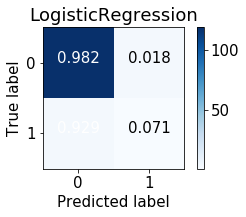

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


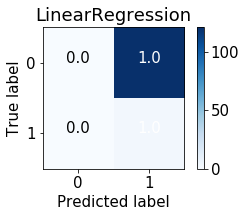

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


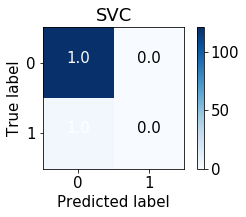

In [20]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()

Normalized confusion matrix
[[0.99450927 0.00549073]
 [1.         0.        ]]


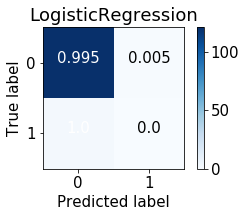

[[120.75         0.66666667]
 [  2.58333333   0.        ]]
Normalized confusion matrix
[[0.99448656 0.00551344]
 [1.         0.        ]]


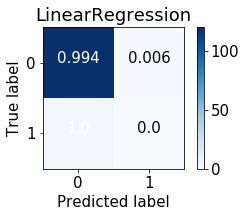

[[120.25         0.66666667]
 [  3.08333333   0.        ]]
Normalized confusion matrix
[[0.99309392 0.00690608]
 [1.         0.        ]]


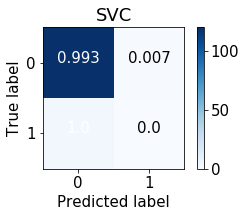

[[119.83333333   0.83333333]
 [  3.33333333   0.        ]]


In [16]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

Normalized confusion matrix
[[0.98832418 0.01167582]
 [0.96875    0.03125   ]]


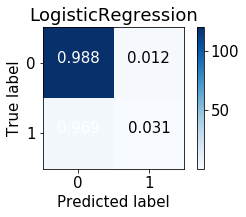

Normalized confusion matrix
[[0.08160443 0.91839557]
 [0.14285714 0.85714286]]


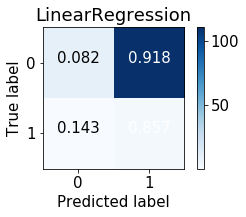

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


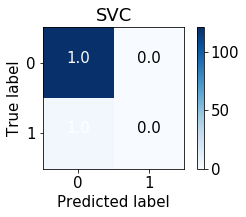

In [22]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)